In [55]:
from os import listdir
from collections import defaultdict
from math import comb, ceil

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker
import seaborn as sns

import pandas as pd

sns.set()
sns.set_palette("bright")
sns.set_style("whitegrid")

matplotlib.rcParams['font.serif'] = "cmr10"
matplotlib.rcParams['font.family'] = 'serif'

In [ ]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return f"<p>{fontname}: <span style='font-family:{fontname}; font-size:24px;'>{fontname}</p>"

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist])) if "cm" in font])

HTML("<dif style='column-count:2;'>{}</div>".format(code))

In [5]:
import shutil
import matplotlib

shutil.rmtree(matplotlib.get_cachedir())

# RUN DATA

## AMD:

Model name:          AMD EPYC 7452 32-Core Processor

Kernel: 4.18.0-372.9.1.el8.x86_64

## Intel:

Model name:          Intel(R) Xeon(R) CPU E7-8890 v4 @ 2.20GHz

Kernel: 4.18.0-348.2.1.el8_5.x86_64

In [106]:
for m in ["amd/", "intel/", ""]:
    di = f"res/{m}"
    checksums = {}
    for fn in listdir(di):
        if "txt" not in fn:
            continue
        acc = 0
        ran = 0
        sel = 0
        with open(di + fn) as inf:
            for l in inf:
                if "access_check" in l:
                    acc = int(l.split()[-1])
                elif "rank_check" in l:
                    ran = int(l.split()[-1])
                elif "select_check" in l:
                    sel = int(l.split()[-1])
        ds = fn.split('_')[-1]
        if ds not in checksums:
            checksums[ds] = [(fn, acc, ran, sel)]
        else:
            checksums[ds].append((fn, acc, ran, sel))
    print(m, ":")
    for ds, tups in checksums.items():
        print("======", ds, "=======")
        acc = defaultdict(int)
        ran = defaultdict(int)
        sel = defaultdict(int)
        for t in tups:
            acc[t[1]] += 1
            ran[t[2]] += 1
            if "HYB" not in t[0]:
                sel[t[3]] += 1
        acc_c = sorted(acc.items(), key=lambda x: -x[1])[0][0]
        ran_c = sorted(ran.items(), key=lambda x: -x[1])[0][0]
        sel_c = sorted(sel.items(), key=lambda x: -x[1])[0][0]
        print(acc_c, ran_c, sel_c)
        for t in tups:
            if t[1] != acc_c:
                print(t)
                continue
            if t[2] != ran_c:
                print(t)
                continue
            if "HYB" not in t[0] and t[3] != sel_c:
                print(t)

amd/ :
====== rnd-50.16MB.txt =======
4993939 335600574756625 671349745601225
('HYBRRR_256_32_rnd-50.16MB.txt', 4993570, 335600576641746, 335600576641746)
====== bv-dump.bin.txt =======
2503280 10455494743730396 40748480512100248
('HYBRRR_256_32_bv-dump.bin.txt', 2491100, 10455494726011306, 10455494726011306)
====== WT-DNA-1GB.txt =======
5828270 22782127594449568 43290239141063738
('HYBRRR_256_32_WT-DNA-1GB.txt', 5826645, 22782127590998922, 22782127590998922)
====== WT-WEB-1GB.txt =======
5288645 23338635564356618 42481085257560706
('HYBRRR_256_32_WT-WEB-1GB.txt', 5288026, 23338635551616740, 23338635551616740)
intel/ :
====== rnd-50.16MB.txt =======
4993939 335600574756625 671349745601225
('HYBRRR_256_32_rnd-50.16MB.txt', 4993570, 335600576641746, 335600576641746)
====== bv-dump.bin.txt =======
2503280 10455494743730396 40748480512100248
('HYBRRR_256_32_bv-dump.bin.txt', 2491100, 10455494726011306, 10455494726011306)
====== WT-DNA-1GB.txt =======
5828270 22782127594449568 432902391410

In [107]:
stuff = []
for machine in ["amd/", "intel/", ""]:
    di = f"res/{machine}"
    for fn in listdir(di):
        if "txt" not in fn:
            continue
        d = {}
        with open(di + fn) as inf:
            for l in inf:
                if "access_time" in l:
                    d["access"] = float(l.split()[-1])
                elif "plain_size" in l:
                    d["elems"] = float(l.split()[-1])
                elif "rank_time" in l:
                    d["rank"] = float(l.split()[-1])
                elif "select_time" in l and "HYB" not in fn:
                    d["select"] = float(l.split()[-1])
                elif "rrr_size" in l:
                    d["size_bytes"] = float(l.split()[-1])
        fn_arr = fn.split('_')
        d["data_set"] = fn_arr[-1]
        d["type"] = fn_arr[0]
        d["block_size"] = fn_arr[1]
        if "GAP" in fn or "LOO" in fn:
            d["gap_size"] = fn_arr[3]
        d["OPT"] = False if "NOOPT" in fn else True
        d["machine"] = machine if machine else "laptop"
        if d["type"] == "SDSL" and d["block_size"] == "256":
            continue
        stuff.append(d)

df = pd.DataFrame.from_dict(stuff)

In [6]:
testset = "laptop"

In [89]:
files = ['WT-WEB-1GB.txt', 'WT-DNA-1GB.txt', 'bv-dump.bin.txt']#, 'rnd-50.16MB.txt']

In [10]:
def gap_bytes(b, g):
    acc = 0
    types = (b + 1) // 2;
    for i in range(types + 1):
        acc += (comb(b, i) + g - 1) / g;
    return (acc * b + 7) / 8;

def deBrujin_bytes(b):
    acc = b;
    for i in range(1, (b + 1) // 2 + 1):
        acc += comb(b, i) + 1
    return (acc + 7) / 8

/tmp/ipykernel_252633/2254426196.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(1, 3, i + 1)


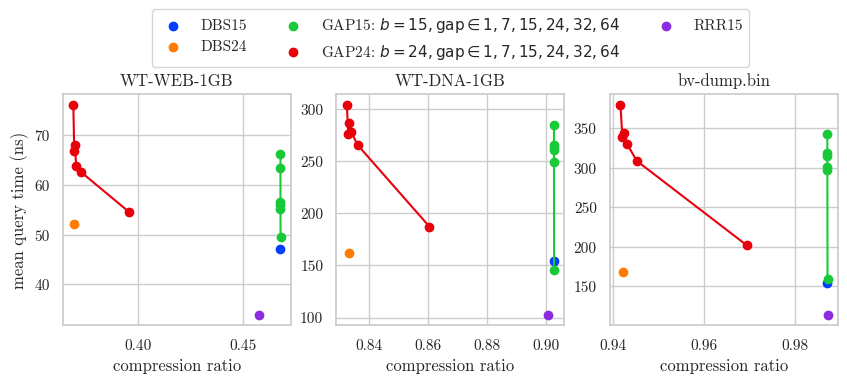

In [111]:
sdf = df[df["machine"] == testset]
sdf = sdf[sdf["type"].isin(["H0GAP", "RRR", "H0WDBS"])]
plt.figure(figsize=(10, 3))
for i, dat in enumerate(files):
    ddf = sdf[sdf["data_set"] == dat]
    plt.subplot(1, 3, i + 1)
    parts = []
    tdf = ddf[ddf["type"] == "H0GAP"]
    tdf = tdf[tdf["block_size"] == "15"]
    sdat = sorted([
        (int(g), t, (s + gap_bytes(15, int(g))) / e) 
        for g, t, s, e 
        in zip(tdf["gap_size"], tdf["access"], tdf["size_bytes"], tdf["elems"])
    ])
    parts.append((f"GAP15: $b =15, \\text{{gap}} \in {{{','.join(str(t[0]) for t in sdat)}}}$", [t[1] for t in sdat], [t[2] for t in sdat]))

    tdf = ddf[ddf["type"] == "H0GAP"]
    tdf = tdf[tdf["block_size"] == "24"]
    sdat = sorted([
        (int(g), t, (s + gap_bytes(24, int(g))) / e) 
        for g, t, s, e 
        in zip(tdf["gap_size"], tdf["access"], tdf["size_bytes"], tdf["elems"])
    ])
    parts.append((f"GAP24: $b =24, \\text{{gap}} \in {{{','.join(str(t[0]) for t in sdat)}}}$", [t[1] for t in sdat], [t[2] for t in sdat]))

    tdf = ddf[ddf["type"] == "H0WDBS"]
    for a, s, e, t, b in zip(tdf["access"], tdf["size_bytes"], tdf["elems"], tdf["type"], tdf["block_size"]):
        parts.append((f"{t[3:]}{b}", [a],  [(s + ((2**(int(b) - 1) + int(b)) / 8)) / e]))

    tdf = ddf[ddf["type"] == "RRR"]
    for a, s, e, t, b in zip(tdf["access"], tdf["size_bytes"], tdf["elems"], tdf["type"], tdf["block_size"]):
        parts.append((f"{t}{b}", [a],  [(s + (2**int(b) * 15 / 8)) / e]))

    parts.sort()

    for k, (l, a, s) in zip(sns.color_palette(), parts):
        plt.scatter(s, a, color=k, label=l)
        if len(a) > 1:
            plt.plot(s, a, color=k)
    if i == 0:
        plt.ylabel("mean query time (ns)")
    plt.xlabel("compression ratio")
    if i == 1:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=3, fancybox=True)
    plt.title(dat[:-4])

plt.savefig(f"lookup_tables_{testset}.pdf", bbox_inches='tight')
plt.show()


/tmp/ipykernel_252633/3889239842.py:5: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(1, 3, i + 1)


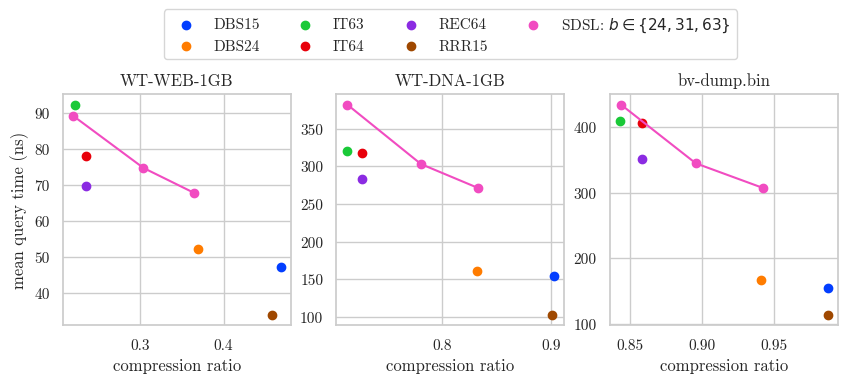

In [122]:
sdf = df[df["machine"] == testset]
sdf = sdf[sdf["type"].isin(['H0I', 'H0R', 'H0WDBS', 'RRR', 'SDSL'])]
plt.figure(figsize=(10, 3))
for i, dat in enumerate(files):
    plt.subplot(1, 3, i + 1)
    ddf = sdf[sdf["data_set"] == dat]
    pats = []
    tdf = ddf[ddf["type"] == "SDSL"]
    tdf = tdf[tdf["OPT"] == True]
    sdat = sorted([(b, a, s / e) for a, s, e, b in zip(tdf["access"], tdf["size_bytes"], tdf["elems"], tdf["block_size"])])[1:]
    pats.append((f"SDSL: $b\in \\{{{','.join(str(t[0]) for t in sdat)}\\}}$", [t[1] for t in sdat], [t[2] for t in sdat]))
    tdf = ddf[ddf["type"].isin(['H0I', 'H0R', 'H0WDBS', 'RRR'])]
    tmap = {
        'H0I': 'IT',
        'H0R': 'REC',
        'H0WDBS': 'DBS',
        'RRR': 'RRR'
    }
    for a, s, e, t, b, o in zip(tdf["access"], tdf["size_bytes"], tdf["elems"], tdf["type"], tdf["block_size"], tdf["OPT"]):
        if o == False:
            continue
        pats.append((f"{tmap[t]}{b}", [a], [s / e]))

    pats.sort()
    for c, t in zip(sns.color_palette(), pats):
        plt.scatter(t[2], t[1], color=c, label=t[0])
        if len(t[1]) > 1:
            plt.plot(t[2], t[1], color=c)
    if i == 0:
        plt.ylabel("mean query time (ns)")
    plt.xlabel("compression ratio")
    if i == 1:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=4, fancybox=True)
    plt.title(dat[:-4])
plt.savefig(f"overall_{testset}.pdf", bbox_inches='tight')
plt.show()

/tmp/ipykernel_252633/3679778297.py:13: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(t[1], t[2], color=c, marker=m, label=f"{t[0][3:-3]}{dat[:-4]}")


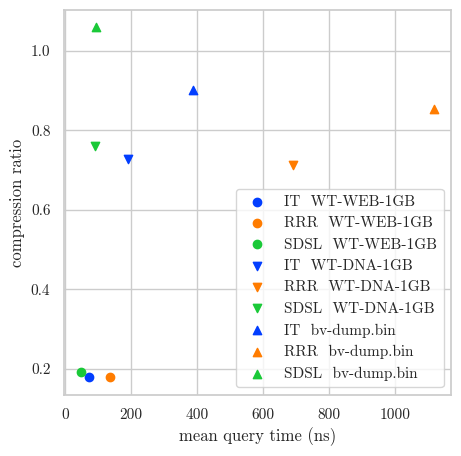

In [116]:
sdf = df[df["machine"] == testset]
sdf = sdf[sdf["type"].str.contains("HYB")]
plt.figure(figsize=(5, 5))
for m, dat in zip("ov^,", files):
    if "rnd" in dat:
        continue
    ddf = sdf[sdf["data_set"] == dat]
    dats = []
    for a, s, e, t, b in zip(ddf["access"], ddf["size_bytes"], ddf["elems"], ddf["type"], ddf["block_size"]):
        dats.append((f"{t}  {b}", [a], [s / e]))
    dats.sort()
    for c, t in zip(sns.color_palette(), dats):
        plt.scatter(t[1], t[2], color=c, marker=m, label=f"{t[0][3:-3]}{dat[:-4]}")
    plt.ylabel("compression ratio")
    plt.xlabel("mean query time (ns)")
    plt.legend()
plt.savefig(f"hybrid_{testset}.pdf", bbox_inches='tight')
plt.show()

/tmp/ipykernel_252633/3939591419.py:5: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(1, 3, i + 1)


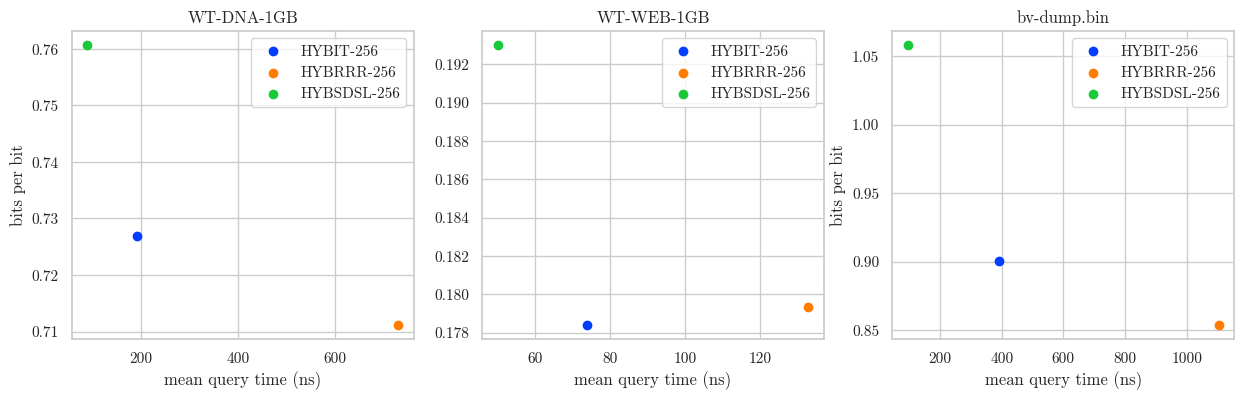

In [45]:
sdf = df[df["machine"] == testset]
sdf = sdf[sdf["type"].str.contains("HYB")]
plt.figure(figsize=(15, 4))
for i, dat in enumerate(files):
    plt.subplot(1, 3, i + 1)
    ddf = sdf[sdf["data_set"] == dat]
    dats = []
    for a, s, e, t, b in zip(ddf["access"], ddf["size_bytes"], ddf["elems"], ddf["type"], ddf["block_size"]):
        dats.append((f"{t}-{b}", [a], [s / e]))
    dats.sort()
    for c, t in zip(sns.color_palette(), dats):
        plt.scatter(t[1], t[2], color=c, label=t[0])
    if i % 2 == 0:
        plt.ylabel("bits per bit")
    plt.xlabel("mean query time (ns)")
    plt.legend()
    plt.title(dat[:-4])
plt.savefig(f"hybrid_{testset}.pdf", bbox_inches='tight')
plt.show()